In [10]:
#Loading data
import pandas as pd

data_path = 'sneakers2023.csv'
df = pd.read_csv(data_path)
df = df.drop(df.columns[0], axis = 1).dropna()
print(df.shape)

(1910, 17)


['retail', 'lowestAsk', 'numberOfAsks', 'salesThisPeriod', 'highestBid', 'numberOfBids', 'annualHigh', 'annualLow', 'volatility', 'deadstockSold', 'pricePremium', 'averageDeadstockPrice', 'lastSale', 'changePercentage']


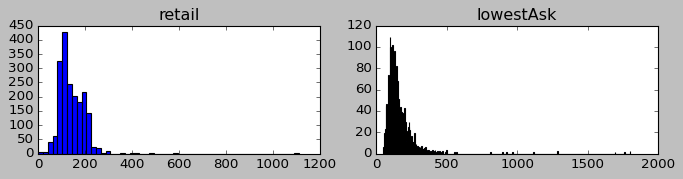

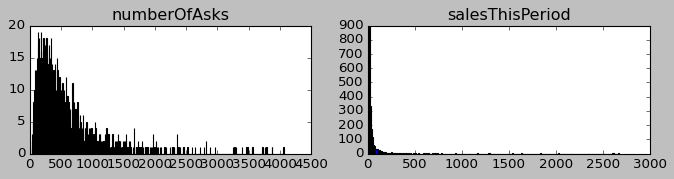

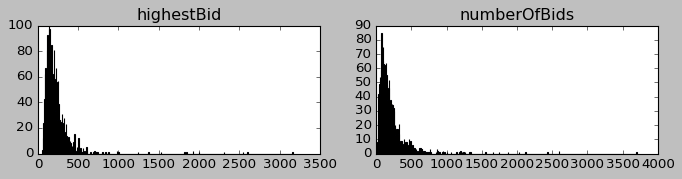

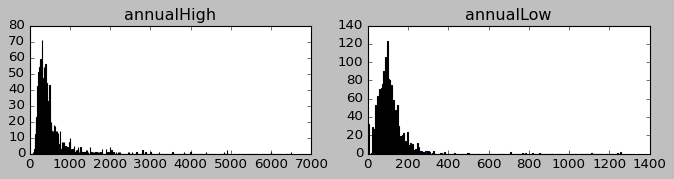

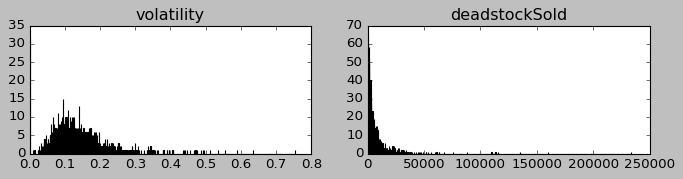

float64


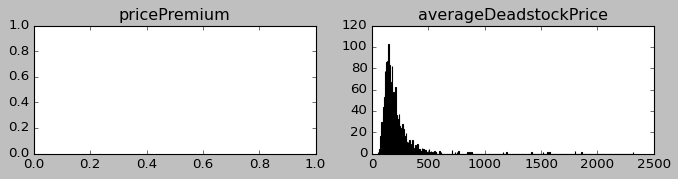

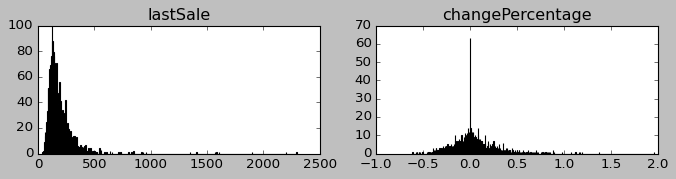

<Figure size 800x160 with 0 Axes>

item: 
brand: 
release: 


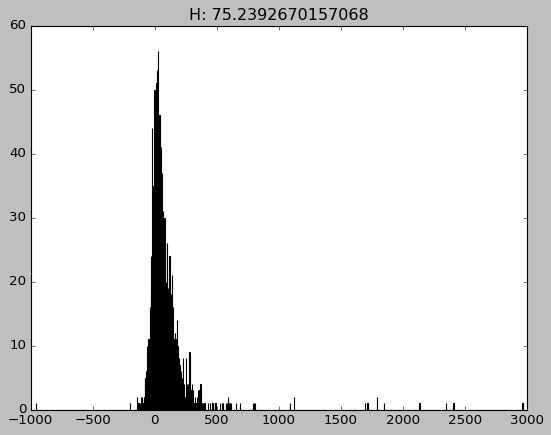

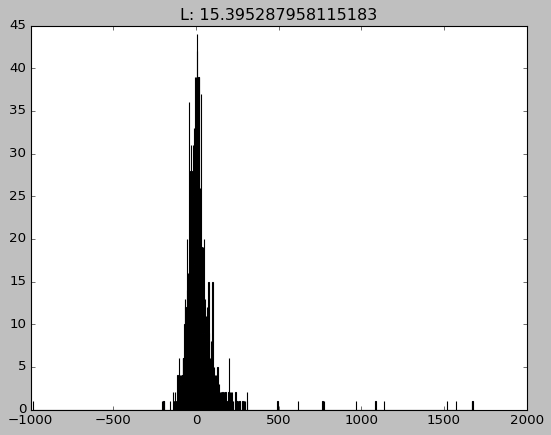

In [11]:
#Looking at dataframe
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use("classic")

#df.info()


numeric = [col for col in df.columns if type(df.iloc[0][col]) != type("strings")]

#Histograms for numeric data
def make_numerical_hists():
    
    print(numeric)
    n_cols = len(numeric)

    plt.figure(figsize = [10, 2])
    for idx, col in enumerate(numeric):
        try:
            plt.subplot(1, 2, idx % 2 + 1)
            plt.title(col)
            plt.hist(df[col], bins = len(np.unique(df[col])))
            if idx % 2 != 0:
                plt.show()
                plt.figure(figsize = [10, 2])
        except:
            print(df[col].dtype)
    plt.show()

make_numerical_hists()


#Unique values of categoricals
cats = [col for col in df.columns if df[col].dtype == "object"]
for col in cats:
    try:
        print(col + ": ")
        unique = np.unique(df[col])
        if len(unique) < 10:
            for val in unique:
                if df[col].tolist().count(val) < 10:
                    shoe_names = [row['item'] for idx, row in df.iterrows() if row.brand == val]
                    print(f"\t{val}: {shoe_names}")
                else:
                    print(f"\t{val}: {df[col].tolist().count(val)}")
    except Exception as e:
        print(e)
        

#Looking at difference between retail and highest/lowest bids

highest_diff = df.highestBid - df.retail
lowest_diff = df.lowestAsk - df.retail
plt.title("H: " + str(np.mean(highest_diff))); plt.hist(highest_diff, bins = len(highest_diff)); plt.show()
plt.title("L: " + str(np.mean(lowest_diff))); plt.hist(lowest_diff, bins = len(lowest_diff)); plt.show()
#Couple outliers for these that might affect data, but there are also general outliers for retail

c:\Users\adhil\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


(1839, 17)
['retail', 'lowestAsk', 'numberOfAsks', 'salesThisPeriod', 'highestBid', 'numberOfBids', 'annualHigh', 'annualLow', 'volatility', 'deadstockSold', 'pricePremium', 'averageDeadstockPrice', 'lastSale', 'changePercentage']


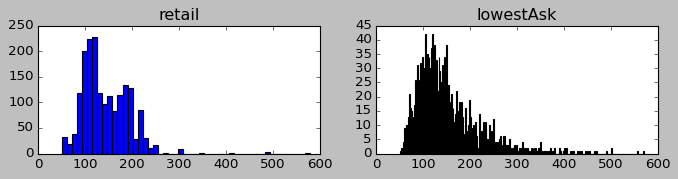

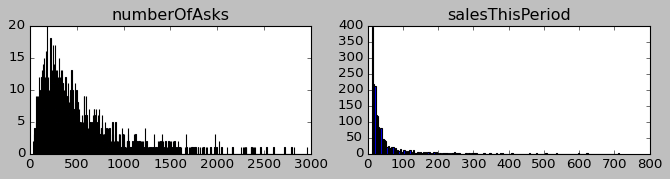

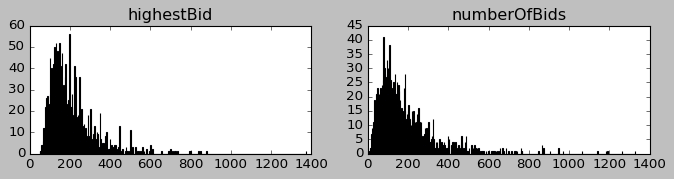

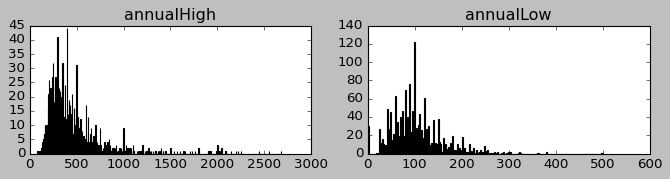

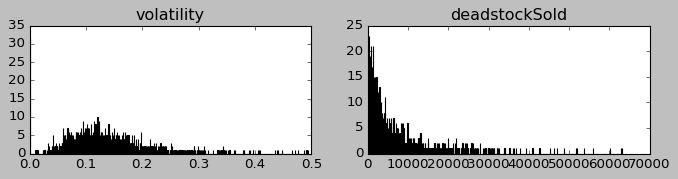

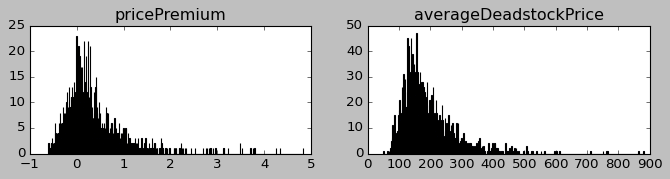

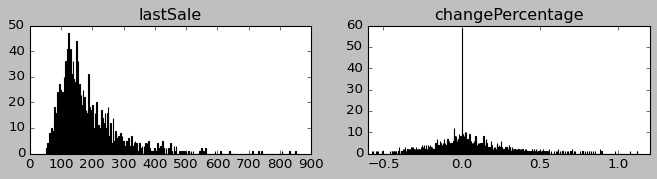

<Figure size 800x160 with 0 Axes>

(1762, 17)


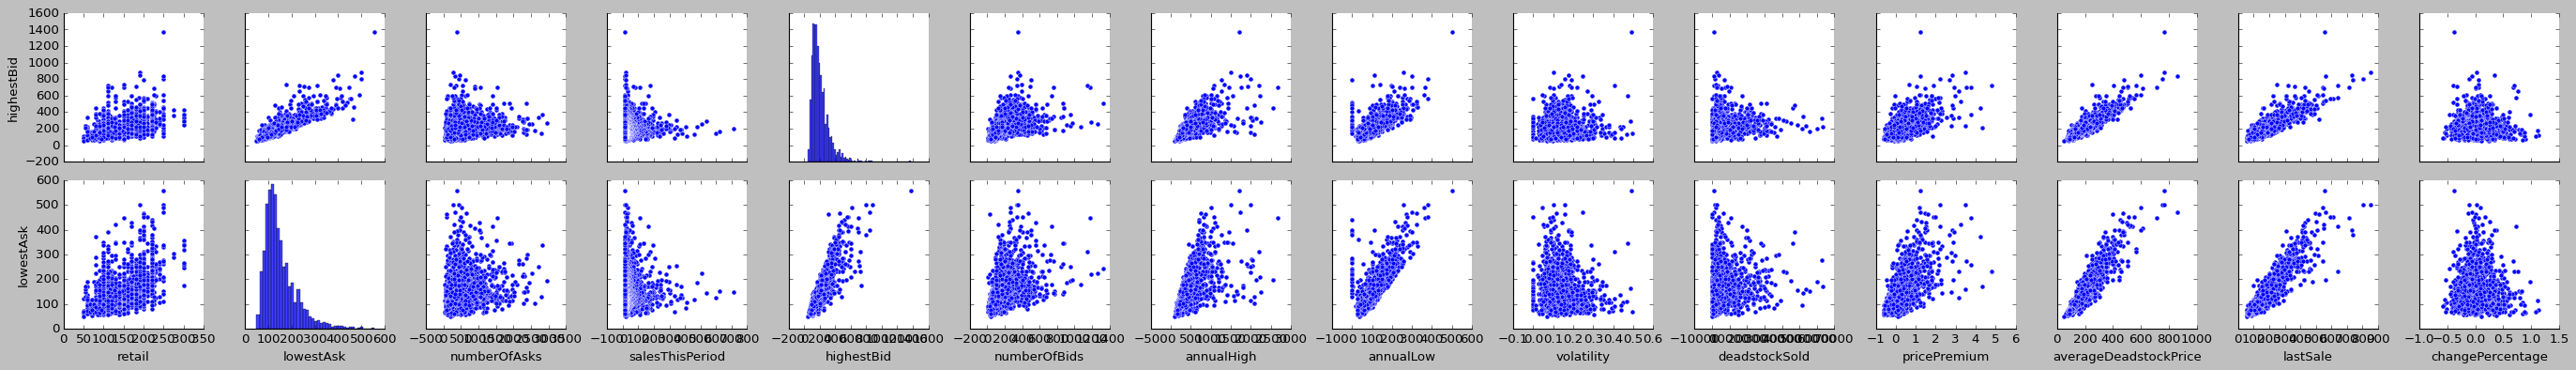

In [12]:
#Filtering data w criteria for removing outliers and underrepresenteted brands

retail_prices = df.retail.tolist()
high_prices = df.highestBid.tolist()
colstats = {}
for col in df.columns:
    if col != "retail" and col != "highestBid" and df[col].dtype != "object":
        colstats[col] = {
            'mean' : np.mean(df[col]),
            'std' : np.std(df[col])
        }


def removable(row):
    if row.highestBid > np.mean(high_prices) + 7 * np.std(high_prices) or row.highestBid < 50:
        return True
    if row.retail < 50 or row.retail > 800:
        return True
    for col in colstats:
        if row[col] > colstats[col]['mean'] + 5*colstats[col]['std'] or row[col] < colstats[col]['mean'] - 5*colstats[col]['std']:
            return True
        
    return False

to_remove = []
for idx, row in df.iterrows():
    if removable(row):
        to_remove.append(idx)
        
df = df.T.drop(to_remove, axis = 1).T
print(df.shape)

make_numerical_hists()
plt.show()



#Replacing the brands with little population in the data as "Other"
to_remove = []
brands_to_remove = [brand for brand in np.unique(df.brand) if df.brand.tolist().count(brand) < 100]
for idx, row in df.iterrows():
    if row.brand in brands_to_remove:
        to_remove.append(idx)
    
df = df.T.drop(to_remove, axis = 1).T
print(df.shape)


#Looking at correlations to highestBid and lowestAsk
import seaborn as sns

sns.pairplot(df.drop('item', axis = 1), y_vars = ['highestBid', 'lowestAsk'])
plt.show()

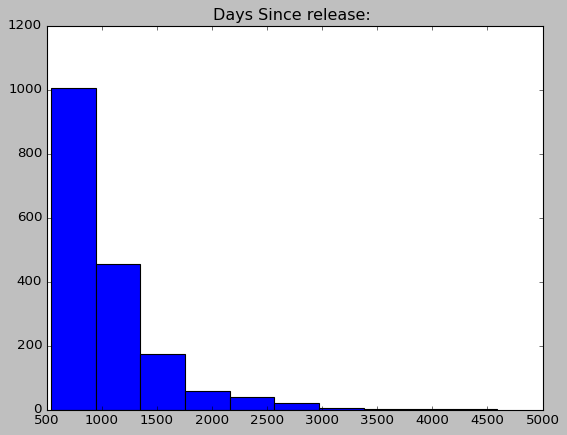

(1731, 17)


C:\Users\adhil\AppData\Local\Temp\ipykernel_13256\3728089072.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"item_{idx}"] = col
C:\Users\adhil\AppData\Local\Temp\ipykernel_13256\3728089072.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"item_{idx}"] = col
C:\Users\adhil\AppData\Local\Temp\ipykernel_13256\3728089072.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using 

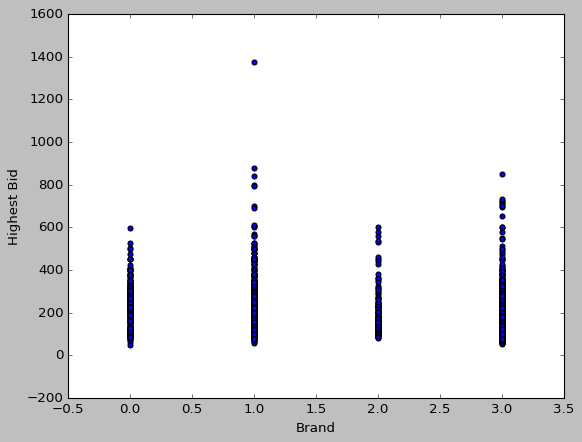

In [13]:
#Preprocessing data
from sklearn.preprocessing import LabelEncoder

#Replacing dates with how old shoe is
from datetime import datetime

if "days_since_release" not in df.columns:
    release_dates =  [datetime.strptime(d, "%Y-%M-%d") for d in df.release.tolist()] 
    df['days_since_release'] = [(datetime.today() - d).days for d in release_dates]
    df = df.drop('release', axis = 1)

    plt.title("Days Since release: ")
    plt.hist(df.days_since_release)
    plt.show()

    to_remove = []
    max_days_since_release = 2500
    for idx, row in df.iterrows():
        if row['days_since_release'] > max_days_since_release:
            to_remove.append(idx)

    df = df.drop(to_remove)
    print(df.shape)



#Removing the brand names and vectorizing
from sklearn.feature_extraction.text import TfidfVectorizer
import string

vectorizer = TfidfVectorizer()

df['item'] = [i.lower().translate(str.maketrans('', '', string.punctuation)) for i in df['item']]
vectorizer.fit(df['item'])
vects = vectorizer.transform(df['item']).toarray()
for idx in range(vects.shape[1]):
    col = [vect[idx] for vect in vects]
    df[f"item_{idx}"] = col


#Label encoding the brands
if type(df.iloc[0].brand) == type("strings"):
    brand_le = LabelEncoder()
    brand_le.fit([i.lower() for i in df.brand])
    df.brand = brand_le.transform([i.lower() for i in df.brand])
    
    plt.scatter(df.brand, df.highestBid)
    plt.xlabel("Brand")
    plt.ylabel("Highest Bid")
    plt.show() #Not that large of a correlation for brands for retail or highest Bid  


#Setting these for training
item_cols = [col for col in df.columns if 'item' in col and col != "item"]
columns_for_highest_bid = ['retail', 'highestBid', 'brand'] + item_cols
columns_for_lowest_ask = ['retail', 'lowestAsk', 'brand', 'days_since_release', 'highestBid'] + item_cols

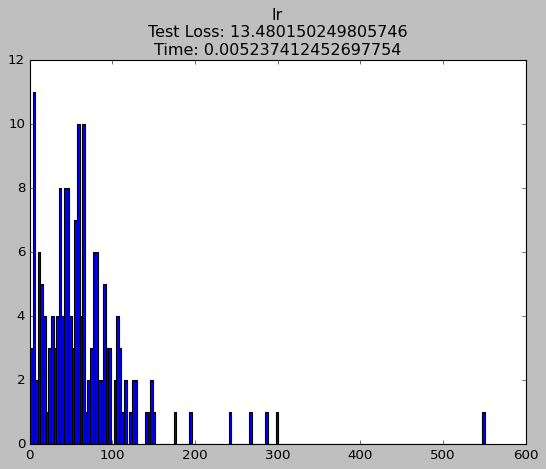

Largest Errors: 
143 significant errors 29 outrageous ones
(174,)




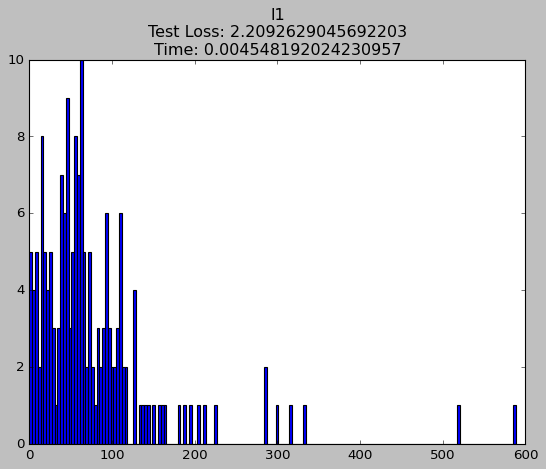

Largest Errors: 
145 significant errors 41 outrageous ones
(174,)




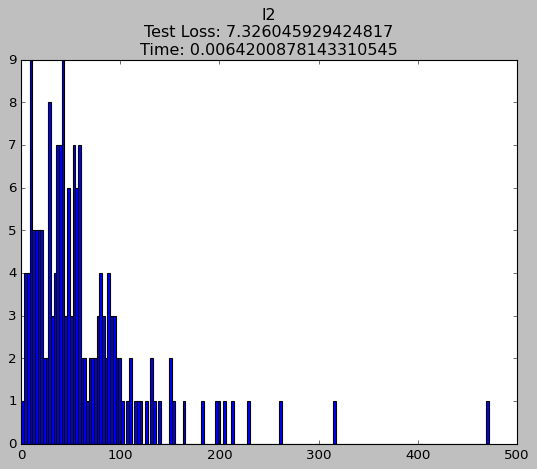

Largest Errors: 
139 significant errors 25 outrageous ones
(174,)




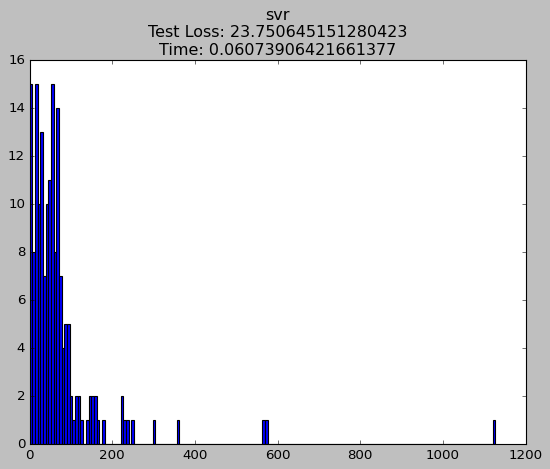

Largest Errors: 
136 significant errors 27 outrageous ones
(174,)




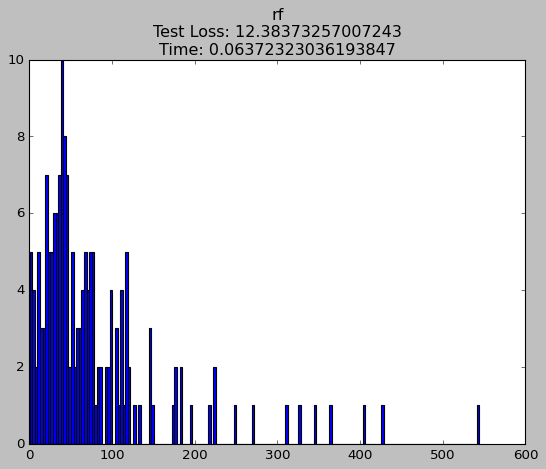

Largest Errors: 
149 significant errors 41 outrageous ones
(174,)




In [14]:
#Pipeline for finding best model for highest bid to see if a shoe is worth buying retail 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import time


#Only can use item, brand, and retail price (EDIT: also shoe and possibly colorway)
x_columns_to_drop = [col for col in df.columns if col not in columns_for_highest_bid]
x = df.copy()
for col in x_columns_to_drop:
    x = x.drop(col, axis = 1)
y = df.highestBid

columns_to_standardize = ['retail']

models_to_test = {
    'lr':LinearRegression(), 'l1':Ridge(), 'l2':Lasso(), 'svr':SVR(), 'rf':RandomForestRegressor()
}

K = 10
best_model = None
lowest_num_below_100 = 10000
for model_name, model in models_to_test.items():
    net_loss = 0
    net_time = 0
    #Cross Validation with multiple splits
    for _ in range(K):
        xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.1)
        
        pipeline = Pipeline([
            ('standardize', ColumnTransformer([('standardize', StandardScaler(), columns_to_standardize)])),
            (model_name, model)
        ])
        
        start = time.time()
        pipeline.fit(xtrain, ytrain)
        net_loss += pipeline.score(xtest, ytest)
        end = time.time()
        net_time += end - start
        
    avg_loss = np.abs(net_loss / K)
    avg_time = net_time / K
    
    preds = pipeline.predict(xtest)
    errors = np.abs(preds - ytest)
    plt.hist(errors, bins = len(errors))
    plt.title(f"{model_name}\nTest Loss: {np.abs(np.average(preds - ytest))}\nTime: {avg_time}")
    plt.show()
    
    #Printed largest errors, which were random
    print("Largest Errors: ")
    
    #Printing amount of significant errors ( > 20) and outrageous ones ( > 100)
    significant_errors = [error for error in errors if error > 20]
    outrageous_errors = [error for error in significant_errors if error > 100]

    if len(outrageous_errors) < lowest_num_below_100:
        lowest_num_below_100 = len(outrageous_errors)
        best_model = pipeline

    print(f"{len(significant_errors)} significant errors {len(outrageous_errors)} outrageous ones")
    print(errors.shape)
    print("\n")

    
#Marking the best model
highest_bid_predictor = best_model

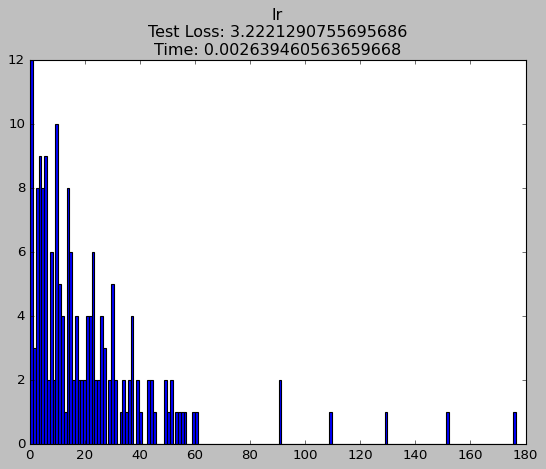

Largest Errors: 
70 significant errors 4 outrageous ones
(174,)






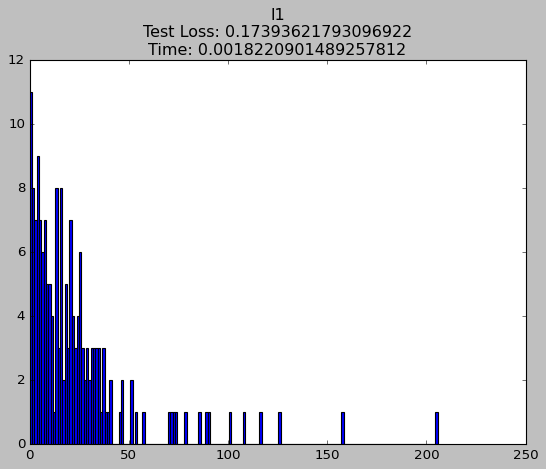

Largest Errors: 
75 significant errors 6 outrageous ones
(174,)






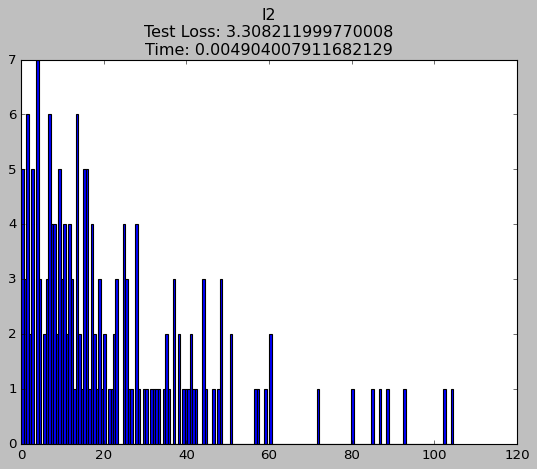

Largest Errors: 
68 significant errors 2 outrageous ones
(174,)






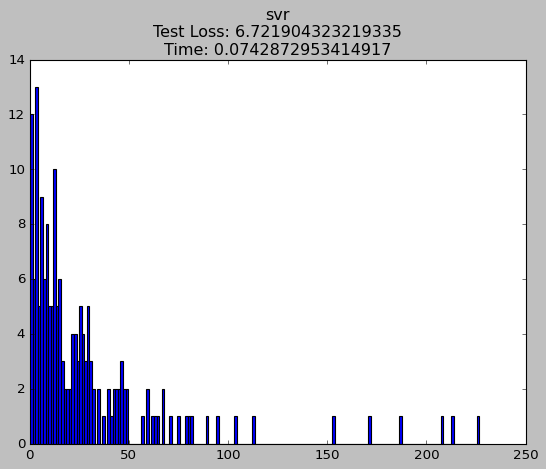

Largest Errors: 
76 significant errors 8 outrageous ones
(174,)






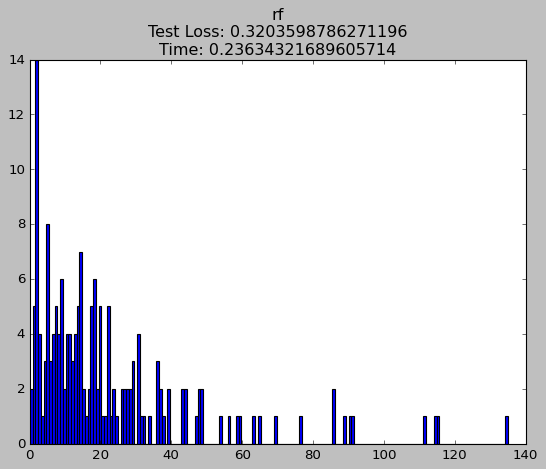

Largest Errors: 
65 significant errors 4 outrageous ones
(174,)






In [15]:
#Doing the same to predict what the price will drop down to after a certain amount of days


x_columns_to_drop = [col for col in df.columns if col not in columns_for_lowest_ask]
x = df.copy()
for col in x_columns_to_drop:
    x = x.drop(col, axis = 1)
y = df.lowestAsk

columns_to_standardize = ['retail', 'highestBid']
columns_to_standardize = [col for col in columns_to_standardize if col not in x_columns_to_drop]

models_to_test = {
    'lr':LinearRegression(), 'l1':Ridge(), 'l2':Lasso(), 'svr':SVR(), 'rf':RandomForestRegressor()
}

K = 10
best_model = None
lowest_below_50 = 10000
for model_name, model in models_to_test.items():
    net_loss = 0
    net_time = 0
    #Cross Validation with multiple splits
    for _ in range(K):
        xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.1)
        
        pipeline = Pipeline([
            ('standardize', ColumnTransformer([('standardize', StandardScaler(), columns_to_standardize)])),
            (model_name, model)
        ])
        
        start = time.time()
        pipeline.fit(xtrain, ytrain)
        net_loss += pipeline.score(xtest, ytest)
        end = time.time()
        net_time += end - start
        
    avg_loss = np.abs(net_loss / K)
    if avg_loss < lowest_err:
        lowest_err = avg_loss
        best_model = pipeline
    avg_time = net_time / K
    
    preds = pipeline.predict(xtest)
    errors = np.abs(preds - ytest)
    plt.hist(errors, bins = len(errors))
    plt.title(f"{model_name}\nTest Loss: {np.abs(np.average(preds - ytest))}\nTime: {avg_time}")
    plt.show()
    
    #Printing shoes with the greatest errors to see if they are similar
    print("Largest Errors: ")
    
    errors = np.abs(preds - ytest)
     #Printing amount of significant errors ( > 20) and outrageous ones ( > 100)
    significant_errors = [error for error in errors if error > 20]
    outrageous_errors = [error for error in significant_errors if error > 100]

    errors_above_50 = [error for error in significant_errors if error > 50] #Stricter because model performs better than highest bid
    if len(errors_above_50) < lowest_below_50:
        lowest_below_50 = len(errors_above_50)
        best_model = pipeline

    print(f"{len(significant_errors)} significant errors {len(outrageous_errors)} outrageous ones")
    print(errors.shape)
    print("\n")
        
    print("\n")

    
#Marking the best model
lowest_ask_predictor = best_model

In [16]:
#Tried LSTM-based neural network, didn't work too well

In [17]:
#Deleting previous pickled files

import os 

delete = True

if delete:
    for file in os.listdir("./"):
        if ".pkl" in file:
            os.remove(file)

In [18]:
#Exporting models to pickle
import joblib

if not os.path.exists("highest_bid_predictor.pkl"):
    joblib.dump(highest_bid_predictor, "highest_bid_predictor.pkl")
    joblib.dump(lowest_ask_predictor, 'lowest_ask_predictor.pkl')
    joblib.dump(brand_le, 'brand_le.pkl')
    joblib.dump(vectorizer, 'vectorizer.pkl')